# BLU05 - Learning Notebook - Optional Part 4 - SARIMAX Interactive Example

In [1]:
import utils 
from sklearn.metrics import r2_score

import pandas as pd 
import numpy as np 
import statsmodels.api as sm  # <--- Yay! API! 
%matplotlib inline 

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 5)

import itertools

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)   
warnings.filterwarnings("ignore") # specify to ignore warning messages

# Using season and exogenous variables

So far, we have been using only the endogenous variable to create predictions. Also, the time series we used are ... kind of easy. Highly seasonal and periodic, eventhough the variance might increase over time. But they are easy. So, what about making things a "little bit" harder? Like, for example, predicting the US GDP Growth.

In [2]:
import pandas as pd

from statsmodels import api as sm

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

If you want additional insights on each of the time series of this dataset, check this page at [thebalance.com](https://www.thebalance.com/components-of-gdp-explanation-formula-and-chart-3306015).

In [3]:
data = pd.read_csv('data/US_Production_Q_Data_Growth_Rates.csv')

data.Year = pd.to_datetime(data.Year)

data = data.set_index('Year')

data.head(10)

,GDP Growth,Consumption Growth,Investment Growth,Government Purchases Growth,Exports Growth,Imports Growth,Capital Growth,Labor Growth
Year,,,,,,,,
1948-01-01,2.8,2.4,21.1,-3.6,-14.8,18.4,3.5,1.9
1948-04-01,4.5,2.7,32.0,1.0,-30.6,14.1,3.8,1.8
1948-07-01,5.2,2.0,34.9,5.9,-29.0,25.1,4.2,2.3
1948-10-01,3.8,2.2,13.4,11.9,-22.5,15.8,4.7,0.4
1949-01-01,0.9,1.2,-11.6,14.4,-7.3,-2.5,4.9,-2.0
1949-04-01,-1.0,1.8,-33.5,15.4,2.0,-6.8,4.6,-3.6
1949-07-01,-0.5,2.1,-26.7,13.9,-7.1,-14.8,4.0,-5.4
1949-10-01,-1.5,3.3,-29.4,8.8,-16.8,-8.4,3.5,-4.8
1950-01-01,3.8,5.1,9.7,2.5,-30.3,0.6,3.0,-2.4


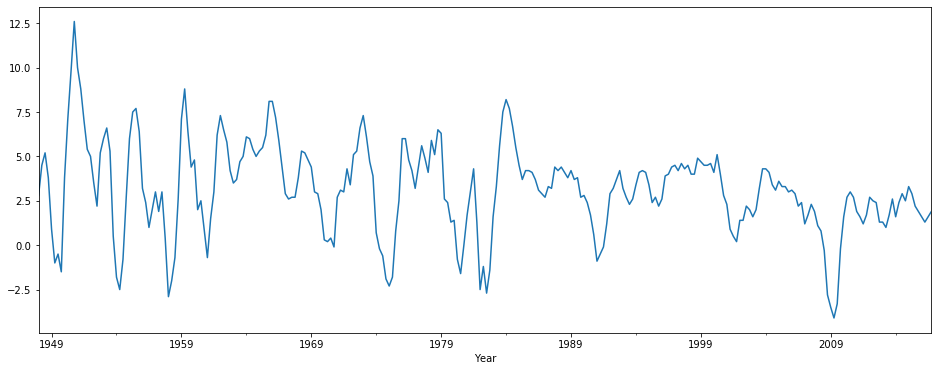

In [4]:
data['GDP Growth'].plot(figsize=(16, 6));

Can you see any seasonality? Me neither. But you might notice that, from time to time, there is a big drop in GDP Growth (to negative values). That is related to economical cycles. Hmmm...cycles...maybe a cyclical component is present?

**ALSO**, Remember the 2007 crisis? Well, it is no surprise that we had the biggest recession near ~2009. 

Let's plot all time series together to see if there is a pattern

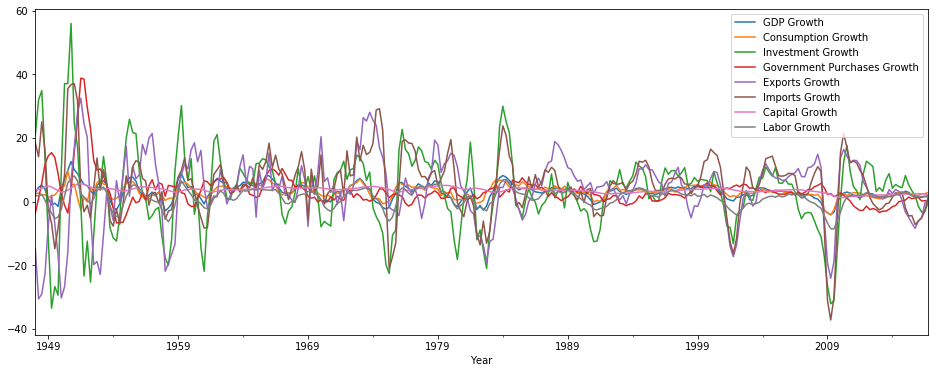

In [5]:
data.plot(figsize=(16, 6));

Well...maybe it wasn't a good idea. Let's instead make several plots, one for each pair (GDP Growth, OTHER TIME SERIES)

In [6]:
from itertools import product

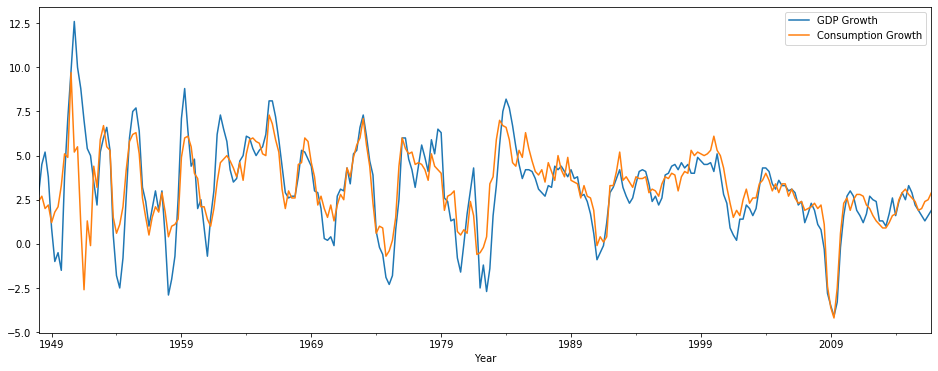

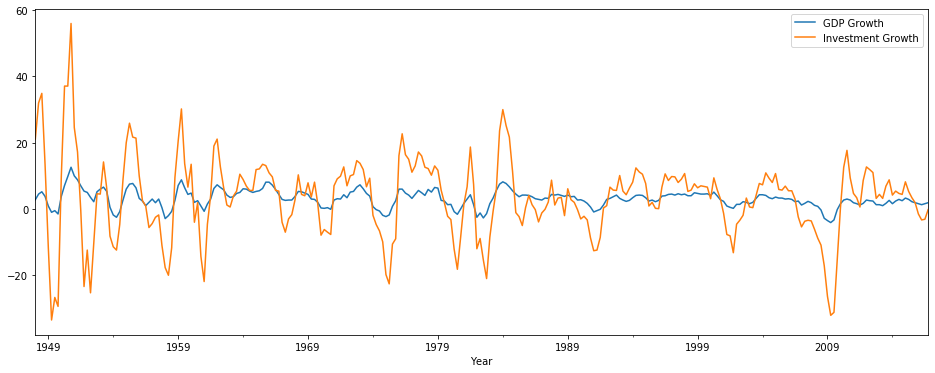

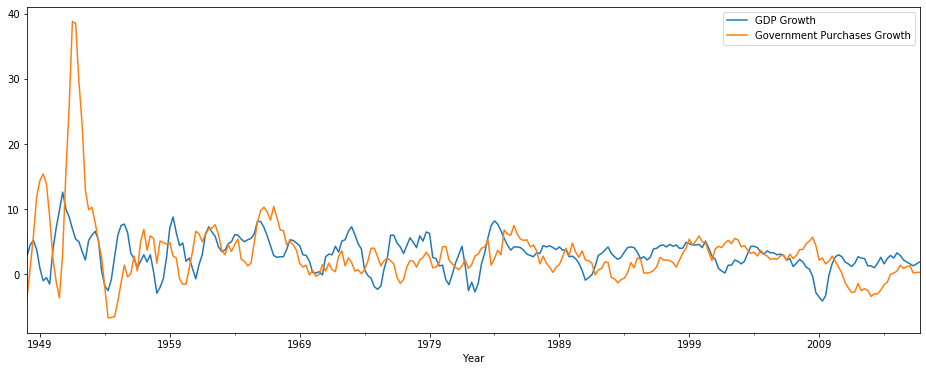

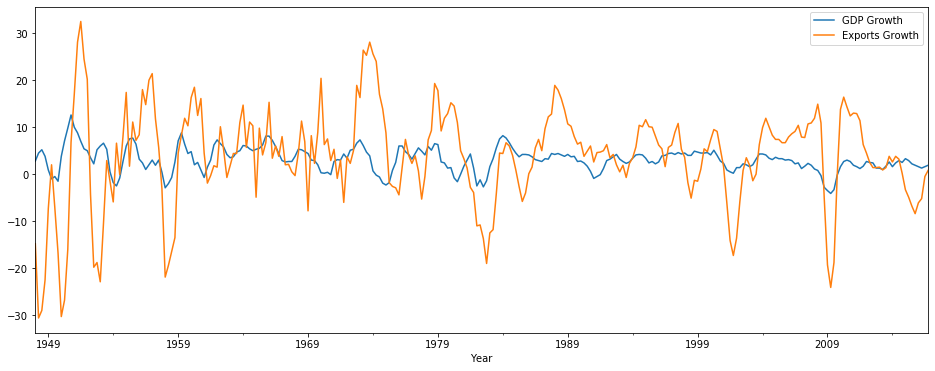

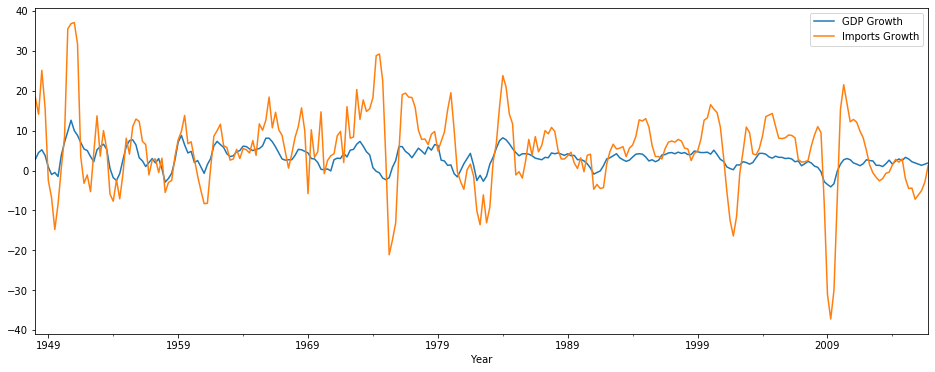

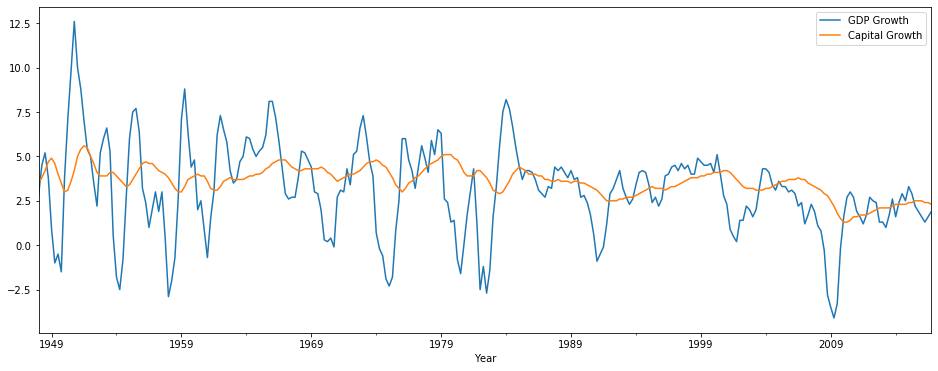

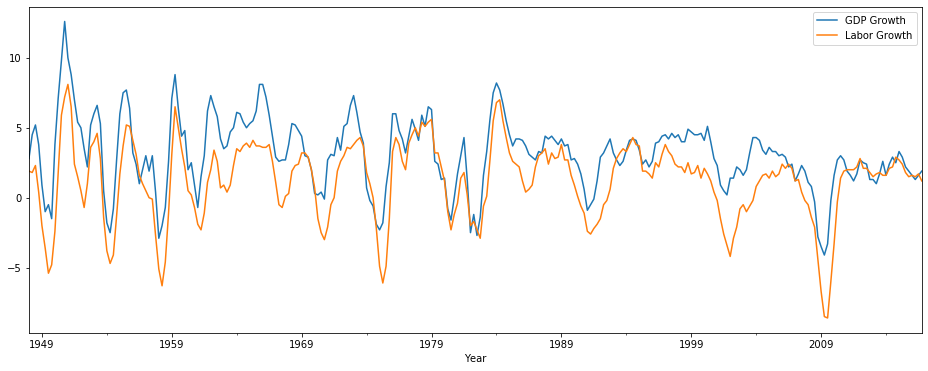

In [7]:
for gdp, other in product(['GDP Growth'], data.drop('GDP Growth', axis=1).columns): 
    data[[gdp, other]].plot(figsize=(16, 6))
    plt.show()

By visual inspection, we that Consumption Growth and Labor Growth follow GDP Growth like two puppies. So, one reasonable hypothesis is: those two time series are highly predictive for GDP Growth. Instead of trying to find the best model using grid search, we will let you explore the effect of each exogenous variable and model parameter in the forecast. 

First, let's prepare the train test split and, also, add some cyclical features for month and decade

In [8]:
import numpy as np


X = data.drop('GDP Growth', axis=1)
X['month (cosine)'] = np.cos(2 * np.pi * X.index.month/ 12)
X['month (sin)'] = np.sin(2 * np.pi * X.index.month/ 12)
X['decade (cosine)'] = np.cos(2 * np.pi * (X.index.year % 10) / 10)
X['decade (sine)'] = np.sin(2 * np.pi * (X.index.year % 10) / 10)

y = data['GDP Growth']

train_percentage = 0.5
train_size = int(X.shape[0] * train_percentage)

X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]
X_test, y_test = X.iloc[train_size:], y.iloc[train_size:]

In [9]:
from ipywidgets import interact
from ipywidgets import fixed
from ipywidgets import FloatSlider
from ipywidgets import IntSlider
from ipywidgets import Checkbox
from ipywidgets import Dropdown
from ipywidgets import SelectMultiple

In [10]:
def sarimax_fit_and_plot(endo_train, endo_test, 
                         exog_train=None, exog_test=None, 
                         use_exog=False, 
                         exog_selected=None, 
                         trend='n', 
                         maxiter=50,
                         forecast_steps=None, 
                         p=1, d=0, q=0, 
                         P=0, D=0, Q=0, s=0):
    if use_exog:
        exog_selected = list(exog_selected)
    
        exog_train = exog_train[exog_selected]
        exog_test = exog_test[exog_selected]
    
    if use_exog:
        sarimax = sm.tsa.SARIMAX(endo_train, exog=exog_train, 
                                 order=(p, d, q), trend=trend, 
                                 seasonal_order=(P, D, Q, s))
    else:
        sarimax = sm.tsa.SARIMAX(endo_train, 
                                 order=(p, d, q), trend=trend, 
                                 seasonal_order=(P, D, Q, s))

    sarimax_results = sarimax.fit(maxiter=maxiter, 
                                  trend=trend)
    
    if forecast_steps is None:
        forecast_steps = len(y_test)
        
    if use_exog:
        exog_test = exog_test.iloc[:forecast_steps]
        forecast = sarimax_results.get_forecast(
            steps=forecast_steps, exog=exog_test).predicted_mean
    else:
        forecast = sarimax_results.get_forecast(
            steps=forecast_steps).predicted_mean
    
    plot_forecast_target(forecast, endo_test)


def plot_forecast_target(forecast, target):
    plt.figure(figsize=(16, 6))
    forecast.plot(label="prediction")
    target = target.iloc[:len(forecast)]
    target.plot(label="target")
    plt.ylabel(target.name)
    plt.legend()
    plt.title("R²: {}".format(r2_score(target, forecast)))

In [11]:
interact(sarimax_fit_and_plot, 
         endo_train=fixed(y_train), 
         endo_test=fixed(y_test), 
         exog_train=fixed(X_train), 
         exog_test=fixed(X_test), 
         use_exog=Dropdown(options=[True, False]), 
         exog_selected=SelectMultiple(
             options=list(X.columns),
             value=[X.columns[0]], 
             rows=X.shape[1],
             description='Exogenous features',
             disabled=False
         ), 
         trend=Dropdown(options=['n','c','t','ct']), 
         maxiter=IntSlider(value=50, 
                           min=10, 
                           max=5000, 
                           step=10), 
         forecast_steps=IntSlider(value=50, 
                                  min=10, 
                                  max=len(y_test), 
                                  step=1), 
         p=IntSlider(value=1, 
                     min=0, 
                     max=20, 
                     step=1), 
         d=IntSlider(value=0, 
                     min=0, 
                     max=2, 
                     step=1), 
         q=IntSlider(value=0, 
                     min=0, 
                     max=10, 
                     step=1), 
         P=IntSlider(value=0, 
                     min=0, 
                     max=10, 
                     step=1), 
         D=IntSlider(value=0, 
                     min=0, 
                     max=2, 
                     step=1), 
         Q=IntSlider(value=0, 
                     min=0, 
                     max=10, 
                     step=1), 
         s=IntSlider(value=0, 
                     min=0, 
                     max=40, 
                     step=1));

interactive(children=(Dropdown(description='use_exog', options=(True, False), value=True), SelectMultiple(desc…

**NOTE**: if your CPU starts to cry for help, press stop to interrupt the execution and change the parameters.